## Import CSV

In [1]:
import pandas
def read_csv(filename,folder):
    folder=folder+"/"+filename+".csv"
    return pandas.read_csv(folder,encoding='ISO-8859-1')

In [2]:
PERD_INDEX="VFINX"
folder='/nfs/Workspace/'
RES_PATH='Result'
data=read_csv(filename="TEST",folder=folder)
data.columns = ( 'DATE','VFINX','^SP500TR','VMOT','RWM','DOG','SH','GLD','USO')
data = data.fillna(method='ffill')
data.head()

,DATE,VFINX,^SP500TR,VMOT,RWM,DOG,SH,GLD,USO
0,2019-08-30,265.023315,5898.229980,23.169899,41.254547,53.297012,26.470428,143.750000,91.680000
1,2019-08-29,264.817871,5893.649902,23.101868,41.165298,53.336716,26.460512,144.119995,94.239998
2,2019-08-28,261.462280,5818.839844,22.963835,41.879318,54.021534,26.807505,145.160004,93.120003
3,2019-08-27,259.750244,5780.790039,22.928339,42.385082,54.587254,26.995869,145.570007,91.360001
4,2019-08-26,260.591614,5799.339844,22.938200,41.780151,54.319283,26.876900,144.190002,89.440002


## Visualize Data

In [3]:
from matplotlib import pyplot
def plot_data(dataset,groups):
    i = 1
    pyplot.figure()
    values = dataset.values
    for group in groups:
        pyplot.subplot(len(groups), 1, i)
        pyplot.plot(values[:, group])
        pyplot.title(dataset.columns[group], y=0.5, loc='right')
        i += 1
    pyplot.show()

In [ ]:
plot_data(data,groups=range(1,len(data.columns)-1))

## Data Summary

In [ ]:
data.describe()

## Independent and identically distributed (I.I.D.) Testing

In [ ]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
#sm.graphics.tsa.plot_acf(data['vfx'].values, lags=40)
#print(data['VFINX'])
sm.graphics.tsa.plot_acf(data['VFINX'].values, lags=40)
plt.show()

## Histogram

In [ ]:
data.plot(kind="hist",bins=50)

## Normal Test 

In [ ]:
from scipy import stats
for group in data.columns[1:]:
    print(stats.shapiro(data[group].values))
#print(stats.shapiro(data['spx'].values))

## *** LSTM ***

In [4]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
def Standard_MinMax(data):
    sc = MinMaxScaler(feature_range = (0, 1))
    return sc.fit_transform(data.reshape(-1,1))

In [5]:
#folder="/root/bigdataanalysis/test/"
#data=read_csv(filename="FEAT_DATA",folder=folder)
#data.columns = ( 'DATE','vfx' ,'vix' ,'vbx' ,'rom', 'vmt','rwm','dog','psh', 'spx')
#if not data.get('DATE', None):
del data['DATE']
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(data)
data.head()
#print(scaled)

,VFINX,^SP500TR,VMOT,RWM,DOG,SH,GLD,USO
0,265.023315,5898.229980,23.169899,41.254547,53.297012,26.470428,143.750000,91.680000
1,264.817871,5893.649902,23.101868,41.165298,53.336716,26.460512,144.119995,94.239998
2,261.462280,5818.839844,22.963835,41.879318,54.021534,26.807505,145.160004,93.120003
3,259.750244,5780.790039,22.928339,42.385082,54.587254,26.995869,145.570007,91.360001
4,260.591614,5799.339844,22.938200,41.780151,54.319283,26.876900,144.190002,89.440002


## Series to Supervised

In [6]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pandas.DataFrame(data)
	cols, names = list(), list()
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pandas.concat(cols, axis=1)
	agg.columns = names
    
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [7]:
reframed = series_to_supervised(scaled, 1, 1)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
1,0.867774,0.868484,0.105944,0.324259,0.130623,0.110565,0.944898,0.319588,0.864526,0.865239,0.094340,0.316452,0.133644,0.109200,0.956100,0.366716
2,0.864526,0.865239,0.094340,0.316452,0.133644,0.109200,0.956100,0.366716,0.811481,0.812225,0.070797,0.378909,0.185742,0.156975,0.987587,0.346097
3,0.811481,0.812225,0.070797,0.378909,0.185742,0.156975,0.987587,0.346097,0.784417,0.785262,0.064743,0.423149,0.228779,0.182910,1.000000,0.313697
4,0.784417,0.785262,0.064743,0.423149,0.228779,0.182910,1.000000,0.313697,0.797718,0.798407,0.066425,0.370235,0.208393,0.166530,0.958220,0.278351
5,0.797718,0.798407,0.066425,0.370235,0.208393,0.166530,0.958220,0.278351,0.752405,0.753260,0.036492,0.411005,0.252941,0.210210,0.957614,0.279823


In [8]:
pred = {PERD_INDEX: 8}
reframed = pandas.concat([reframed.iloc[:,0:8],reframed.iloc[:,pred[PERD_INDEX]]],axis=1)
reframed.head()


,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,0.867774,0.868484,0.105944,0.324259,0.130623,0.110565,0.944898,0.319588,0.864526
2,0.864526,0.865239,0.094340,0.316452,0.133644,0.109200,0.956100,0.366716,0.811481
3,0.811481,0.812225,0.070797,0.378909,0.185742,0.156975,0.987587,0.346097,0.784417
4,0.784417,0.785262,0.064743,0.423149,0.228779,0.182910,1.000000,0.313697,0.797718
5,0.797718,0.798407,0.066425,0.370235,0.208393,0.166530,0.958220,0.278351,0.752405


In [9]:
len(reframed.values)

230

## Data Split

In [10]:
train = reframed.values[:200,:]
test = reframed.values[200:230,:]
train_X, train_y = train[:, :-1], train[:, -1]
test_X , test_y  = test[:, :-1], test[:, -1]
train_X.shape, train_y.shape, test_X.shape, test_y.shape

((200, 8), (200,), (30, 8), (30,))

## LSTM

In [11]:
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X  = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
train_X.shape, train_y.shape, test_X.shape, test_y.shape

import keras
from keras import layers

model = keras.models.Sequential()
model.add(layers.LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(layers.Dense(1))
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                11800     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 11,851
Trainable params: 11,851
Non-trainable params: 0
_________________________________________________________________


## Training

In [12]:
history = model.fit(train_X, train_y, epochs=100, 
                    batch_size=72, validation_data=(test_X, test_y), 
                    verbose=1, shuffle=False)

Epoch 1/100
3/3 [==============================] - 0s 163ms/step - loss: 0.4199 - val_loss: 0.2535
Epoch 2/100
3/3 [==============================] - 0s 13ms/step - loss: 0.3820 - val_loss: 0.2217
Epoch 3/100
3/3 [==============================] - 0s 6ms/step - loss: 0.3468 - val_loss: 0.1918
Epoch 4/100
3/3 [==============================] - 0s 22ms/step - loss: 0.3133 - val_loss: 0.1638
Epoch 5/100
3/3 [==============================] - 0s 6ms/step - loss: 0.2815 - val_loss: 0.1378
Epoch 6/100
3/3 [==============================] - 0s 25ms/step - loss: 0.2514 - val_loss: 0.1138
Epoch 7/100
3/3 [==============================] - 0s 6ms/step - loss: 0.2229 - val_loss: 0.0919
Epoch 8/100
3/3 [==============================] - 0s 6ms/step - loss: 0.1961 - val_loss: 0.0723
Epoch 9/100
3/3 [==============================] - 0s 6ms/step - loss: 0.1713 - val_loss: 0.0552
Epoch 10/100
3/3 [==============================] - 0s 6ms/step - loss: 0.1485 - val_loss: 0.0407
Epoch 11/100
3/3 [======

## Plot Loss Curve

Populating the interactive namespace from numpy and matplotlib


/opt/conda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


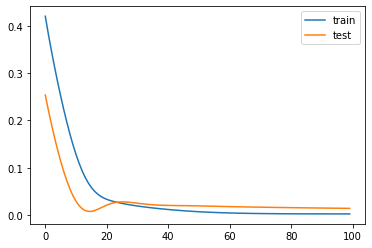

In [13]:
%pylab inline
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

## Model Predict

In [14]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
yhat.shape, test_X.shape

((30, 1), (30, 8))

## Invert scaling for forecast

In [15]:
pred = {PERD_INDEX: 0}
pred,pred[PERD_INDEX]
test_X

array([[0.52040308, 0.51768046, 0.51306479, 0.31701016, 0.32912497,
        0.39393793, 0.03390864, 0.46980848],
       [0.59763142, 0.59463851, 0.5388339 , 0.24656301, 0.23349964,
        0.31834916, 0.05873455, 0.50220911],
       [0.63327642, 0.63021915, 0.59673081, 0.18298934, 0.20137534,
        0.28325455, 0.09809256, 0.52282772],
       [0.64119702, 0.63805672, 0.60342424, 0.1726803 , 0.20585757,
        0.27515509, 0.10566143, 0.55522835],
       [0.55894091, 0.55598942, 0.58736002, 0.23367697, 0.29625426,
        0.35614394, 0.10596425, 0.57290138],
       [0.53441688, 0.53163348, 0.57230005, 0.25085881, 0.32613672,
        0.38044023, 0.11595523, 0.59057441],
       [0.51293933, 0.51012628, 0.59589409, 0.24914102, 0.35975558,
        0.40203687, 0.12443233, 0.5920472 ],
       [0.53685358, 0.53407842, 0.57665086, 0.2585915 , 0.33659602,
        0.37774032, 0.12382669, 0.61413845],
       [0.49648787, 0.4937996 , 0.52979786, 0.33676968, 0.38142058,
        0.41688466, 0.079019

In [16]:
inv_yhat = concatenate((yhat, numpy.delete(test_X, pred[PERD_INDEX], axis=1)), axis=1)
inv_yhat.shape

(30, 8)

In [17]:
scaler = MinMaxScaler(feature_range=(0, 1)).fit(inv_yhat)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
inv_yhat.shape


(30,)

## Invert scaling for actual

In [18]:
real = test_y.reshape((len(test_y), 1))
inv_y = concatenate((real, numpy.delete(test_X, pred[PERD_INDEX], axis=1)), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
inv_y.shape

(30,)

## RMSE

In [19]:
from sklearn.metrics import mean_squared_error
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.056


In [20]:
#inv_y = np.cumprod(inv_y+1)
#inv_yhat = np.cumprod(inv_yhat+1)
inv_y,inv_yhat

(array([0.7751658 , 0.79192615, 0.79565043, 0.75697344, 0.7454422 ,
        0.73534341, 0.74658794, 0.7276079 , 0.70834137, 0.68076623,
        0.69229748, 0.72331052, 0.69065021, 0.74658794, 0.75654393,
        0.76442246, 0.76506712, 0.79163954, 0.79206928, 0.75289122,
        0.76363466, 0.73785005, 0.77573923, 0.83840953, 0.84055833,
        0.84134635, 0.85187488, 0.86727422, 0.86591321, 0.86662933]),
 array([0.75372455, 0.79054574, 0.81374794, 0.82091868, 0.79040162,
        0.782526  , 0.77659908, 0.78658047, 0.76892763, 0.75349908,
        0.72651255, 0.74435488, 0.77095544, 0.73986547, 0.79445237,
        0.81457688, 0.82093432, 0.82128862, 0.85031855, 0.86051163,
        0.82154153, 0.82828296, 0.80072208, 0.83641017, 0.90333345,
        0.90413542, 0.91210328, 0.92394391, 0.94760244, 0.94344195]))

## Predict vs Real

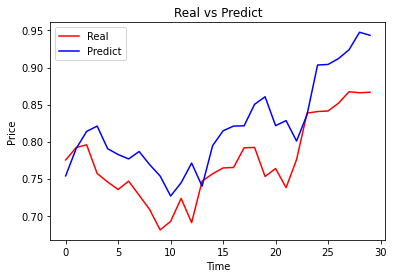

In [21]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(inv_y, color = 'red', label = 'Real')
plt.plot(inv_yhat, color = 'blue', label = 'Predict')
plt.title('Real vs Predict')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

## CNN Data Split (same with LSTM)

In [ ]:
train = reframed.values[:90,:]
print(train.shape)
test = reframed.values[90:100,:]
train_X, train_y = train[:, :-1], train[:, -1]
test_X , test_y  = test[:, :-1], test[:, -1]
train_X.shape, train_y.shape, test_X.shape, test_y.shape

## CNN Data Split

In [ ]:
from keras.layers import Activation, Dense
model = keras.Sequential()
model.add(Dense(5, activation='relu', input_shape=(8,)))
model.add(Dense(5, activation='relu'))
model.add(Dense(1,  activation='sigmoid'))
model.compile(loss='mse',
              optimizer='adam',
              metrics=['mae','mse'])
model.summary()

## Training

In [ ]:
history = model.fit(train_X, train_y, epochs=100, 
                    batch_size=72, validation_data=(test_X, test_y), 
                    verbose=1, shuffle=False)

## Plot Loss Curve

In [ ]:
%pylab inline
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

## Model Predict

In [ ]:
yhat = model.predict(test_X)
yhat.shape, test_X.shape

In [ ]:
pred = {'VFINX': 0}
inv_yhat = concatenate((yhat, numpy.delete(test_X, pred['VFINX'], axis=1)), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
inv_yhat.shape

In [ ]:
real = test_y.reshape((len(test_y), 1))
inv_y = concatenate((real, numpy.delete(test_X, pred['VFINX'], axis=1)), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
inv_y.shape

In [ ]:
from sklearn.metrics import mean_squared_error
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

In [ ]:
inv_y = np.cumprod(inv_y+1)
inv_yhat = np.cumprod(inv_yhat+1)

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(inv_y, color = 'red', label = 'Real')
plt.plot(inv_yhat, color = 'blue', label = 'Predict')
plt.title('Real vs Predict')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

## Predict Real DATA

In [ ]:
#res_data=read_csv(filename=RES_PATH,folder=folder)
#res_data.columns = ('DATE','VFINX')
#res_data = res_data.fillna(method='ffill')
#res_data.head()

## Y convert to Category

## Standardize Function

## SVM Classifier

## Plot Decision Boundary